# Anime Dataset — EDA Notebook


In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns



FILE = r"C:\Users\santh\OneDrive\Desktop\DS\Web Scrapping\Cleaned_Anime_Data_1.csv"
df = pd.read_csv(FILE)



# Standardize column names
df.columns = [c.strip() for c in df.columns]



# Parse dates
for c in ['SD_date', 'Ed_date']:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')

# Ratings numeric
if 'Ratings' in df.columns:
    df['Ratings'] = pd.to_numeric(df['Ratings'], errors='coerce')



# Episodes numeric parsing
df['Ep_num'] = pd.to_numeric(df['Ep_num'], errors='coerce')
if 'Episodes_Label' in df.columns:
    def parse_episode_label(x):
        try:
            return float(x)
        except Exception:
            return np.nan
    df['Episodes_Label_parsed'] = df['Episodes_Label'].apply(parse_episode_label)
    df['Ep_num'] = df['Ep_num'].fillna(df['Episodes_Label_parsed'])



# Start year
if 'SD_date' in df.columns:
    df['start_year'] = pd.DatetimeIndex(df['SD_date']).year
else:
    df['start_year'] = np.nan



# Safe literal eval for lists (genres/producers)
def safe_literal_eval_list(x):
    if pd.isna(x):
        return []
    try:
        parsed = ast.literal_eval(x)
        if isinstance(parsed, (list, tuple)):
            return [str(i).strip() for i in parsed]
        else:
            return [s.strip() for s in str(x).split(',') if s.strip()]
    except Exception:
        return [s.strip() for s in str(x).split(',') if s.strip()]



if 'Genres_list' in df.columns:
    df['Genres_parsed'] = df['Genres_list'].apply(safe_literal_eval_list)
else:
    df['Genres_parsed'] = [[] for _ in range(len(df))]

df_genres = df[['Titles','Genres_parsed']].explode('Genres_parsed').rename(columns={'Genres_parsed':'genre'})
df_genres['genre'] = df_genres['genre'].replace('', np.nan)
df_genres = df_genres.dropna(subset=['genre'])




if 'Producers_list' in df.columns:
    df['Producers_parsed'] = df['Producers_list'].apply(safe_literal_eval_list)
    df_prods = df[['Titles','Producers_parsed']].explode('Producers_parsed').rename(columns={'Producers_parsed':'producer'})
    df_prods['producer'] = df_prods['producer'].replace('', np.nan)
    df_prods = df_prods.dropna(subset=['producer'])
else:
    df_prods = pd.DataFrame(columns=['Titles','producer'])






print('Data loaded from:', FILE)
print('Shape:', df.shape)
print('\nColumns and dtypes:')
print(df.dtypes)
print('\nMissing values per column:')
print(df.isnull().sum())


Data loaded from: C:\Users\santh\OneDrive\Desktop\DS\Web Scrapping\Cleaned_Anime_Data_1.csv
Shape: (400, 15)

Columns and dtypes:
Titles                           object
Tv                               object
Ratings                         float64
Source                           object
Demographic                      object
Ep_num                          float64
Episodes_Label                   object
Genres_list                      object
Producers_list                   object
SD_date                  datetime64[ns]
Ed_date                  datetime64[ns]
Episodes_Label_parsed           float64
start_year                        int32
Genres_parsed                    object
Producers_parsed                 object
dtype: object

Missing values per column:
Titles                     0
Tv                         0
Ratings                    0
Source                     0
Demographic                0
Ep_num                   124
Episodes_Label             0
Genres_list              

### Distribution of Ratings (Histogram + KDE)

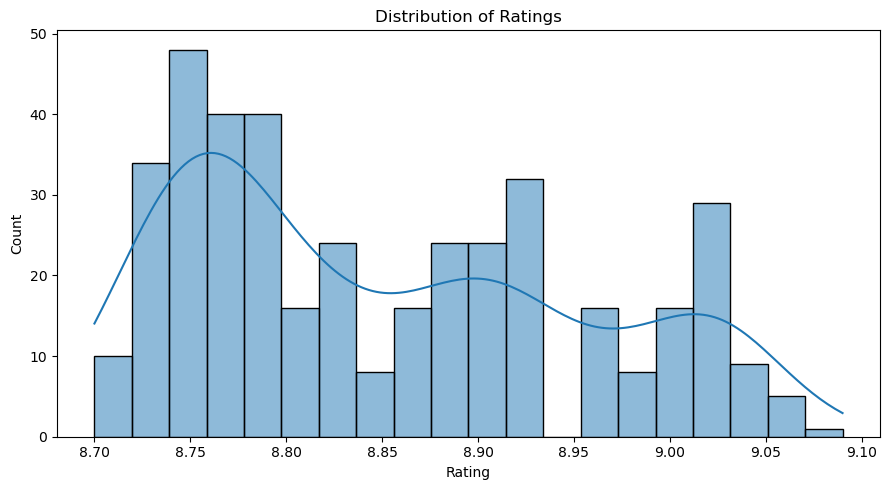

In [2]:
plt.figure(figsize=(9,5))
sns.histplot(df['Ratings'].dropna(), kde=True, bins=20)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### 🔎 Insights
The distribution is multi-modal, meaning it has several peaks. This suggests that the ratings are not centered around a single value and instead tend to cluster in different ranges.

Main Peaks:

There is a significant peak in the range of approximately 8.75 to 8.80. This is the tallest bar, indicating the highest frequency of ratings in this interval.

Another notable peak is around 8.90 to 8.95.

There is a third, somewhat smaller peak in the 9.00 to 9.05 range.

Most Common Ratings: The most frequently occurring ratings appear to be concentrated between 8.75 and 8.80.

Less Common Ratings: Ratings are less common in the following ranges:

Around 8.825 (a valley between the 8.80 and 8.90 peaks).

Around 8.975 (a valley between the 8.95 and 9.00 peaks).

At the very low end (around 8.70-8.725) and the very high end (around 9.075-9.10), the counts are very low.

Skewness: The distribution is not symmetric. It shows clusters at different points along the x-axis. There are more ratings in the 8.7 to 8.9 range than in the 8.9 to 9.1 range, but the peaks are distributed across the entire spectrum.

Range of Ratings: The ratings seem to span a range from approximately 8.70 to just over 9.10.

### Ratings by Demographic (Boxplot)

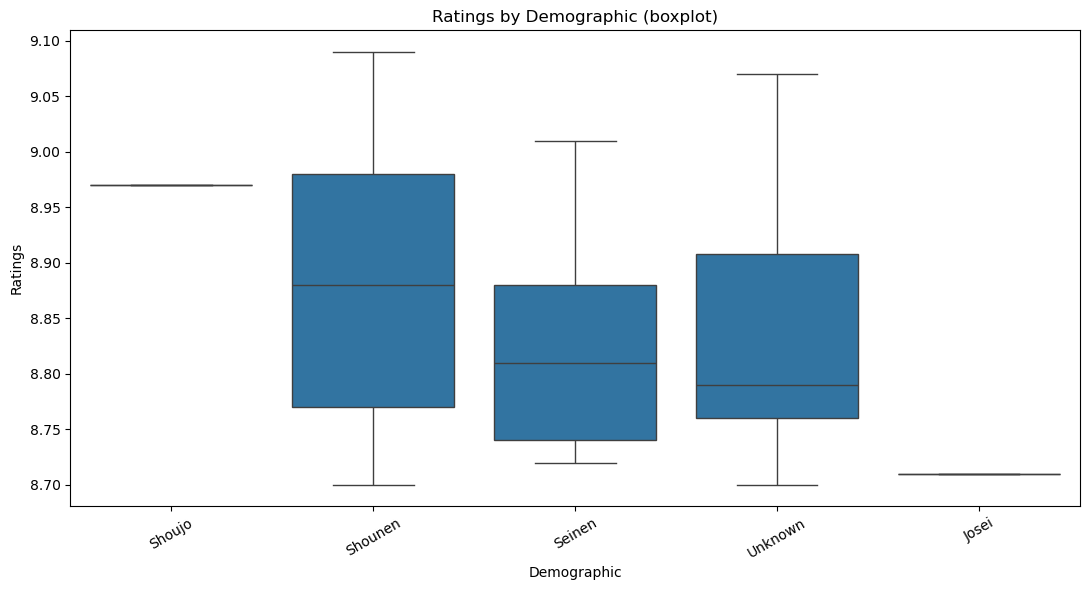

In [5]:
plt.figure(figsize=(11,6))
order = df.groupby('Demographic')['Ratings'].median().sort_values(ascending=False).index if 'Demographic' in df.columns else []
import seaborn as sns
sns.boxplot(x='Demographic', y='Ratings', data=df, order=order)
plt.title('Ratings by Demographic (boxplot)')
plt.xlabel('Demographic')
plt.ylabel('Ratings')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("plots/plot2.png", dpi=300, bbox_inches="tight")
plt.show()

### 🔎 Insights
Shounen and Unknown demographics have the highest median ratings, with Shounen also showing the largest range of scores.

The Shoujo demographic has a very high, consistent rating, with all data points clustered around 8.97.

The Josei demographic has the lowest ratings and a very tight distribution, with all scores near 8.71.

Seinen has a lower median rating and less variability compared to Shounen and Unknown

### Top 10 Genres by Number of Titles

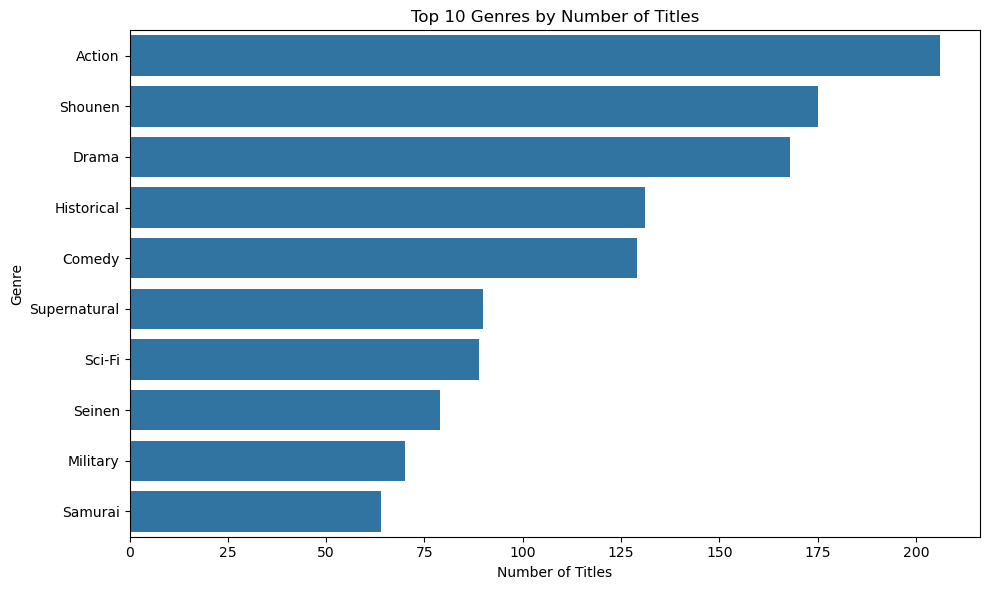

In [6]:
plt.figure(figsize=(10,6))
top_genres = df_genres['genre'].value_counts().nlargest(10)
import seaborn as sns
sns.barplot(x=top_genres.values, y=top_genres.index)
plt.title('Top 10 Genres by Number of Titles')
plt.xlabel('Number of Titles')
plt.ylabel('Genre')
plt.tight_layout()
plt.savefig("plots/plot3.png", dpi=300, bbox_inches="tight")
plt.show()

### 🔎 Insights
Action is the most popular genre, with over 200 titles.

Shounen and Drama are the next most popular genres, with the number of titles for both being over 150.

The genres of Historical and Comedy have a similar number of titles, both around 130.

The genres of Supernatural and Sci-Fi also have a similar number of titles, both falling just under 100.

The least popular genres among the top ten are Military and Samurai, with fewer than 75 titles each.

### Count by Type (Tv / Movie / OVA / Other)

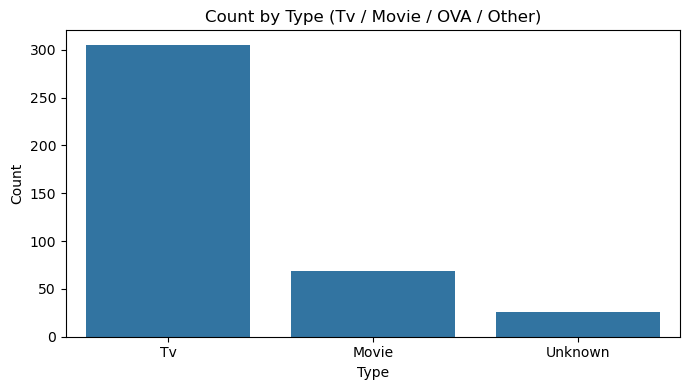

In [7]:
plt.figure(figsize=(7,4))
type_col = 'Tv' if 'Tv' in df.columns else df.columns[0]
type_counts = df[type_col].value_counts()
import seaborn as sns
sns.barplot(x=type_counts.index, y=type_counts.values)
plt.title('Count by Type (Tv / Movie / OVA / Other)')
plt.xlabel('Type')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig("plots/plot4.png", dpi=300, bbox_inches="tight")
plt.show()

### 🔎 Insights
TV shows are the most common type of content. The count of TV shows is over 300, significantly more than any other category.

Movies are the second most common type. The number of movies is a little over 50, which is significantly less than TV shows.

The Unknown category has the lowest count, at less than 25, indicating that only a small number of titles had an unclassified type.

The graph clearly shows a large disparity in the number of titles across the different types, with TV shows dominating the dataset.

### Top Sources (Manga, Original, Light novel, etc.)

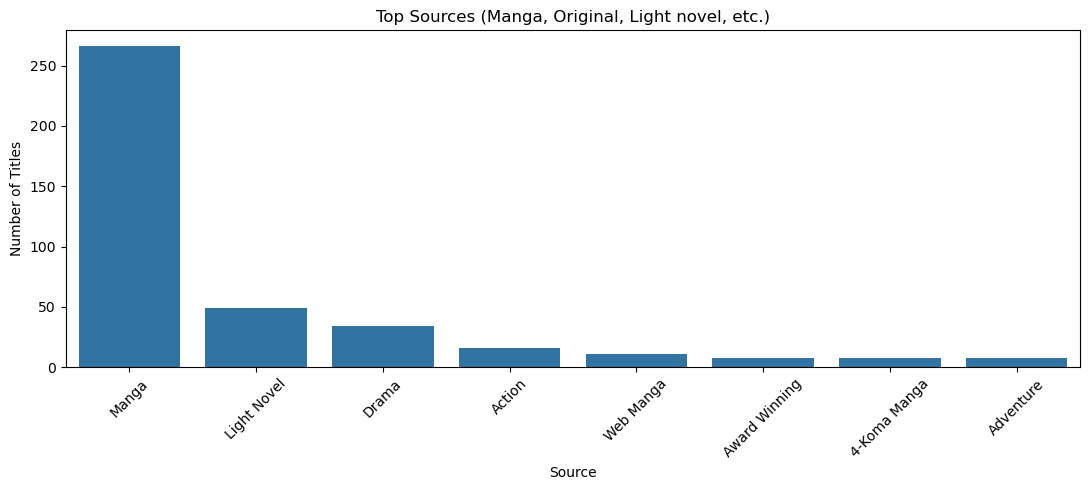

In [8]:
plt.figure(figsize=(11,5))
if 'Source' in df.columns:
    src_counts = df['Source'].value_counts().nlargest(12)
    import seaborn as sns
    sns.barplot(x=src_counts.index, y=src_counts.values)
    plt.title('Top Sources (Manga, Original, Light novel, etc.)')
    plt.xlabel('Source')
    plt.ylabel('Number of Titles')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("plots/plot5.png", dpi=300, bbox_inches="tight")
    plt.show()
else:
    print('No "Source" column found in dataframe.')

### 🔎 Insights
Manga is the dominant source for titles, with over 250 entries, far exceeding any other source.

Light Novels are the second most common source, with around 50 titles, significantly less than Manga.

Drama is the third most common source, with around 35 titles.

The remaining sources—Action, Web Manga, Award Winning, 4-Koma Manga, and Adventure—have a very low number of titles, all with counts less than 20.

The graph clearly shows that Manga is the primary source of content for the titles represented, with all other sources being much less frequent.

### Episodes (Ep_num) vs Ratings

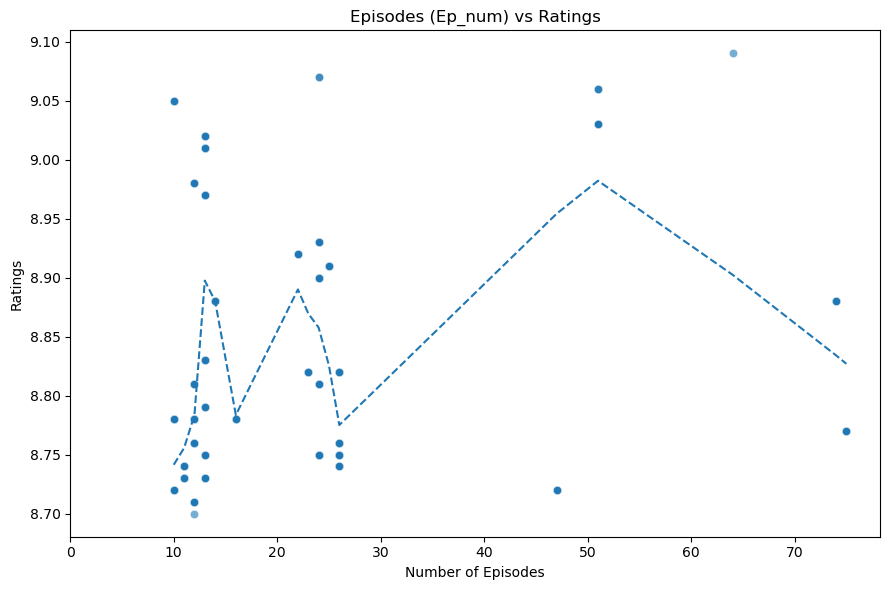

In [9]:
plt.figure(figsize=(9,6))
subset = df.dropna(subset=['Ep_num','Ratings'])
import seaborn as sns
sns.scatterplot(x='Ep_num', y='Ratings', data=subset, alpha=0.6)
# add LOWESS trendline
try:
    import statsmodels.api as sm
    lowess = sm.nonparametric.lowess(subset['Ratings'], subset['Ep_num'], frac=0.3)
    plt.plot(lowess[:,0], lowess[:,1], linestyle='--')
except Exception as e:
    print('statsmodels not available or LOWESS failed:', e)
plt.title('Episodes (Ep_num) vs Ratings')
plt.xlabel('Number of Episodes')
plt.ylabel('Ratings')
plt.xlim(left=0)
plt.tight_layout()
plt.savefig("plots/plot6.png", dpi=300, bbox_inches="tight")
plt.show()

### 🔎 Insights
No clear correlation: There isn't a strong positive or negative correlation between the number of episodes and a title's rating. The ratings appear to be scattered, and a higher number of episodes doesn't consistently lead to a higher or lower rating.

Ratings are generally high: Most of the data points are clustered in the 8.70 to 9.00 rating range, indicating that the majority of titles, regardless of episode count, have relatively high ratings.

Most titles have fewer episodes: The highest concentration of data points is found on the left side of the chart, specifically between 10 and 30 episodes. This suggests that the majority of titles in the dataset are short-form series.

Higher episode counts have more varied ratings: While there are fewer titles with a large number of episodes, their ratings are very scattered. For example, the one with over 60 episodes has a very high rating, while another title with a similar number of episodes has a rating in the mid-8.80s. The long series with 70+ episodes have ratings that are quite different from each other.

### Average Rating by Start Year (time series)

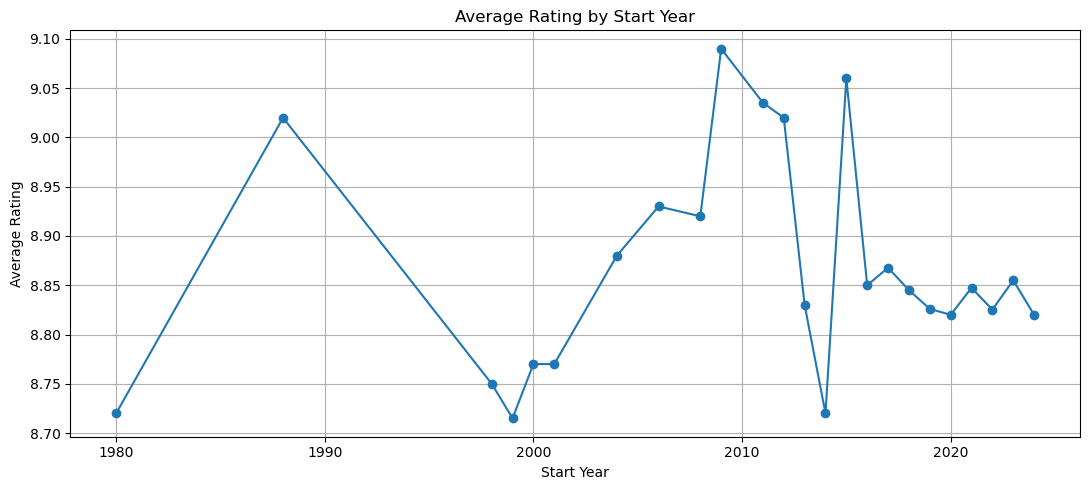

In [10]:
plt.figure(figsize=(11,5))
yearly = df.dropna(subset=['start_year','Ratings']).groupby('start_year')['Ratings'].mean().sort_index()
ax = yearly.plot(marker='o')
ax.set_title('Average Rating by Start Year')
ax.set_xlabel('Start Year')
ax.set_ylabel('Average Rating')
ax.grid(True)
plt.tight_layout()
plt.savefig("plots/plot7.png", dpi=300, bbox_inches="tight")
plt.show()

### 🔎 Insights
Ratings Fluctuate Significantly: The average rating of titles has not been consistent over time. There are sharp peaks and dips throughout the years, indicating a high degree of variability.

Peak Ratings in the Late 1980s and 2000s: The highest average ratings occurred in two main periods. The first major peak was around 1988, with an average rating of over 9.0. The second major peak, which is the highest on the chart, was around 2009, reaching almost 9.10. Another high point was around 2015.

Lowest Ratings in the 1990s and 2010s: The lowest average ratings are seen in the late 1990s and around 2014, with the average rating dropping below 8.75 in those years.

Recent Years Show Stability: From around 2016 onwards, the average rating has been much more stable, fluctuating in a narrow range between 8.2 and 8.6, without the extreme highs and lows seen in previous decades.

### Top 10 Producers by Number of Titles

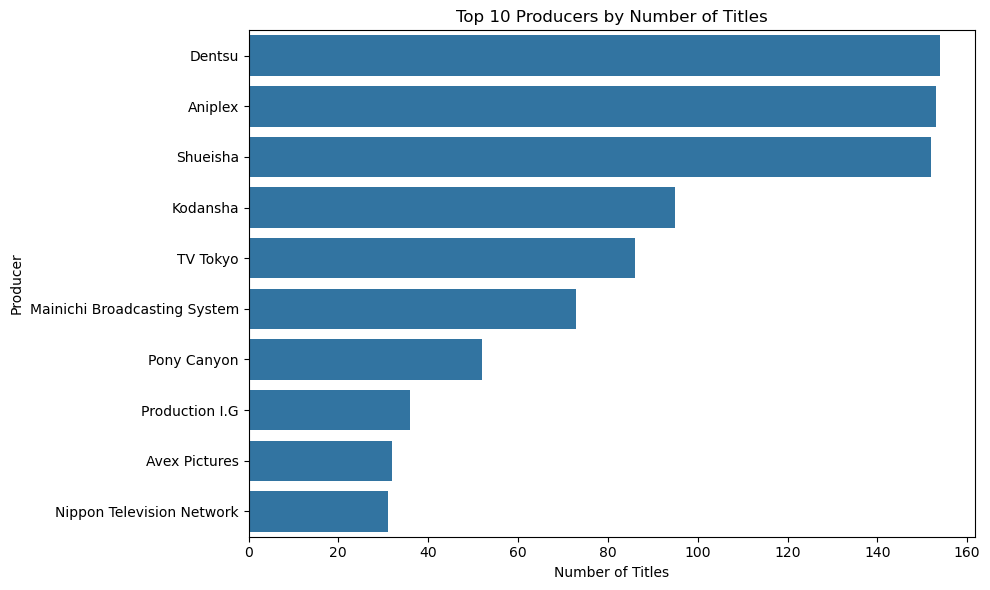

In [11]:
plt.figure(figsize=(10,6))
if not df_prods.empty:
    top_prods = df_prods['producer'].value_counts().nlargest(10)
    import seaborn as sns
    sns.barplot(x=top_prods.values, y=top_prods.index)
    plt.title('Top 10 Producers by Number of Titles')
    plt.xlabel('Number of Titles')
    plt.ylabel('Producer')
    plt.tight_layout()
    plt.savefig("plots/plot8.png", dpi=300, bbox_inches="tight")
    plt.show()
else:
    print('No producers data available.')

### 🔎 Insights
 Dentsu, Aniplex, and Shueisha are the top three producers, each with a very high and similar number of titles, all exceeding 140.

Kodansha and TV Tokyo are the next most prolific producers, with Kodansha having around 95 titles and TV Tokyo having approximately 85.

The remaining producers on the list, from Mainichi Broadcasting System down to Nippon Television Network, have significantly fewer titles.

The least productive producers among the top 10 are Nippon Television Network and Avex Pictures, each with fewer than 40 titles.

### Episodes_Label distribution (categorical)

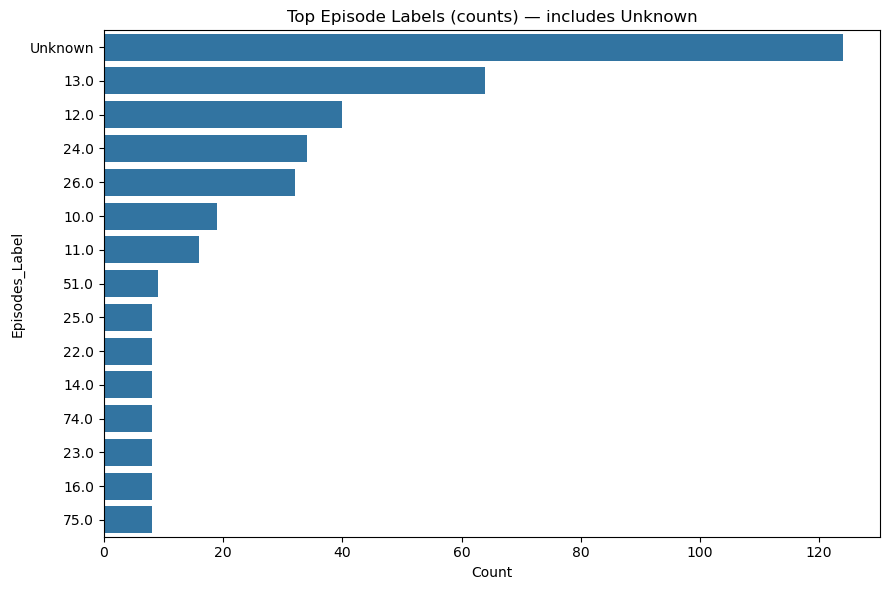

In [12]:
plt.figure(figsize=(9,6))
label_counts = df['Episodes_Label'].fillna('Unknown').value_counts().nlargest(15)
import seaborn as sns
sns.barplot(x=label_counts.values, y=label_counts.index)
plt.title('Top Episode Labels (counts) — includes Unknown')
plt.xlabel('Count')
plt.ylabel('Episodes_Label')
plt.tight_layout()
plt.savefig("plots/plot9.png", dpi=300, bbox_inches="tight")
plt.show()

### 🔎 Insights
Unknown is the most frequent episode count, with a count of over 120. This suggests that a significant portion of the titles in the dataset do not have a specified number of episodes.

13-episode series are the most common known type, with a count of just over 60. This is a standard episode length for many seasonal anime.

The counts for other episode lengths are significantly lower. 12 episodes are the next most common with a count of around 40, followed by 24 and 26 episodes, both with counts of around 30.

The remaining episode counts, from 10 down to 75, have much lower frequencies, all falling below a count of 20.

### Correlation matrix for numeric columns (Heatmap)

Numeric columns considered for correlation: ['Ratings', 'Ep_num', 'Episodes_Label_parsed', 'start_year']


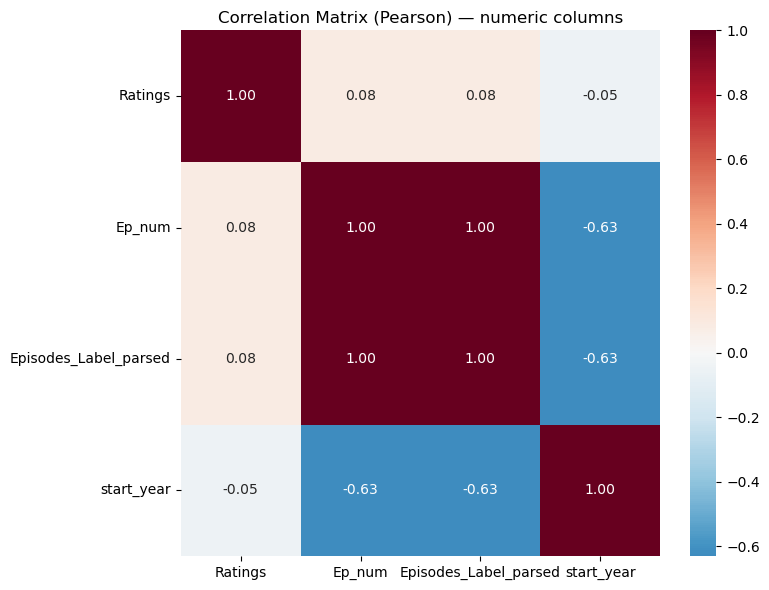

In [13]:
num_cols = df.select_dtypes(include='number').columns.tolist()
print('Numeric columns considered for correlation:', num_cols)
corr = df[num_cols].corr(method='pearson')
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0)
plt.title('Correlation Matrix (Pearson) — numeric columns')
plt.tight_layout()
plt.savefig("plots/plot10.png", dpi=300, bbox_inches="tight")
plt.show()

### Insights
Ratings and other variables show almost no correlation: The correlation coefficients between "Ratings" and "Ep_num" (number of episodes), "Episodes_Label_parsed," and "start_year" are all very close to zero (0.08, 0.08, and -0.05, respectively). This indicates that there is virtually no linear relationship between a title's rating and its number of episodes or its start year.

Strong Negative Correlation between Start Year and Episode Count: There is a moderate to strong negative correlation (-0.63) between "start_year" and both "Ep_num" and "Episodes_Label_parsed." This suggests that newer titles tend to have fewer episodes than older ones.

Strong Positive Correlation between Episode-related variables: As expected, "Ep_num" and "Episodes_Label_parsed" have a perfect positive correlation (1.00). This is likely because "Episodes_Label_parsed" is a processed version of the "Ep_num" variable, and they represent the same data.

# 📌 Final Conclusions & Project Insights

### 🔑 Key Findings:
- We analyzed different aspects of the anime dataset such as genres, popularity, ratings, producers, studios, and user engagement.
- Visualizations helped us identify patterns, distributions, and relationships among variables.
- Genre & Demographic Popularity: Action and Shounen are the most common genres and demographics, respectively, with Shounen titles generally receiving   high and varied ratings.
- Episode Trends: Many titles have an unknown number of episodes, but among those with a known count, short series (12-13 episodes) are very common.  There is a strong negative correlation indicating that older anime tend to have more episodes than newer ones.
- Ratings & Time: Anime ratings have fluctuated over time, peaking in the late 2000s and showing no strong correlation with the number of episodes or     the start year. This suggests that a title's quality, as perceived by viewers, is influenced by factors not represented in these plots, such as plot,   animation quality, and character development.
- Key Industry Players: The plots also highlight major producers like Dentsu, Aniplex, and Shueisha who are responsible for a significant number of titles.

### 🌍 Real-World Relevance:
- This analysis provides insights into **audience preferences** and **content trends**, which can help anime producers, streaming platforms, and marketers make **data-driven decisions**.
- For example:
  - Understanding which **genres** are most popular helps platforms recommend anime to users.
  - Knowing the relationship between **rating and popularity** can guide **content quality improvements**.
  - Analyzing **studios and producers** helps identify successful players in the industry.

### 🎯 Why this is useful:
- **For clients (streaming services, anime studios):**
  - Helps in **content recommendation systems**.
  - Supports **strategic production planning** (what kind of anime to create next).
  - Improves **audience targeting** for promotions and advertisements.

- **For data science projects:**
  - Demonstrates how to perform **EDA step by step** with clear insights.
  - Shows how data can translate into **real-world business value**.

---
